#**Dinky Mishra**
#**CIS 660 | Data Mining**
#**2864923**
#**Lab 4.2 - NIJ Clustering**

# Mounting Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls '/content/drive/MyDrive/Colab Notebooks/datamining/lab04'

DataSet_CustomerCreditcardUsageGENERAL.csv  NIJ2016_AUG01_AUG31_USE_All_0915.xlsx


# **1. Determine Data preprocessing methods to apply for each of your Clustering Algorithm**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,date
from scipy.spatial import distance
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Loading the CSV file
df_nij = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/datamining/lab04/NIJ2016_AUG01_AUG31_USE_All_0915.xlsx')
print(df_nij.head())


        CATEGORY CALL GROUPS final_case_type  \
0  STREET CRIMES    DISORDER          DISTP    
1  STREET CRIMES    DISORDER          DISTP    
2  STREET CRIMES    DISORDER          DISTP    
3  STREET CRIMES    DISORDER          DISTP    
4  STREET CRIMES    DISORDER          DISTP    

                                           CASE DESC   occ_date  x_coordinate  \
0  DISTURBANCE - PRIORITY                        ... 2016-08-01       7639201   
1  DISTURBANCE - PRIORITY                        ... 2016-08-01       7640405   
2  DISTURBANCE - PRIORITY                        ... 2016-08-01       7644614   
3  DISTURBANCE - PRIORITY                        ... 2016-08-01       7646589   
4  DISTURBANCE - PRIORITY                        ... 2016-08-01       7650579   

   y_coordinate  census_tract  
0        683983        5200.0  
1        684344        5200.0  
2        686128        5100.0  
3        686939        2303.0  
4        687362        2402.0  


In [ ]:
df_nij_info = df_nij.info()
df_nij_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19375 entries, 0 to 19374
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   CATEGORY         19375 non-null  object        
 1   CALL GROUPS      19375 non-null  object        
 2   final_case_type  19375 non-null  object        
 3   CASE DESC        19375 non-null  object        
 4   occ_date         19375 non-null  datetime64[ns]
 5   x_coordinate     19375 non-null  int64         
 6   y_coordinate     19375 non-null  int64         
 7   census_tract     18374 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 1.2+ MB


In [ ]:
df_nij_description = df_nij.describe()
df_nij_description

,occ_date,x_coordinate,y_coordinate,census_tract
count,19375,1.937500e+04,19375.000000,18374.000000
mean,2016-08-16 00:32:42.116129280,7.657767e+06,684393.309006,6814.989550
min,2016-08-01 00:00:00,7.607989e+06,632104.000000,100.000000
25%,2016-08-08 00:00:00,7.644084e+06,676195.000000,2203.000000
50%,2016-08-16 00:00:00,7.654454e+06,683590.000000,4900.000000
75%,2016-08-24 00:00:00,7.671818e+06,690155.500000,8202.000000
max,2016-08-31 00:00:00,7.721476e+06,732085.000000,980000.000000
std,NaN,1.702672e+04,12294.223821,40151.218865


# Step 1: Preprocessing

In [ ]:
df_nij['CASE DESC'] = df_nij['CASE DESC'].str.strip()

In [ ]:
# Handle Missing Values
# We will check for missing values in the dataset
missing_values = df_nij.isnull().sum()
missing_values

,0
CATEGORY,0
CALL GROUPS,0
final_case_type,0
CASE DESC,0
occ_date,0
x_coordinate,0
y_coordinate,0
census_tract,1001


Most columns in the dataset do not have missing values, but the census_tract column contains 1001 missing entries. The approach to handle these missing values depends on the importance of the column and the overall dataset size:


*   If the census_tract column is not critical to our clustering analysis, we might consider removing the column altogether.
*   If the column is important and removing 1001 rows won’t significantly affect the dataset, we could opt to drop the rows with missing values.
*   Alternatively, if every row is essential, we could impute the missing values in the census_tract column using a central tendency method (such as the mean or median) or apply another imputation technique.

In our case, we are addressing the 1001 missing values in census_tract using KNN imputation.





In [ ]:
from sklearn.impute import KNNImputer

# Set up the KNNImputer - by default, it uses a k of 5
imputer = KNNImputer(n_neighbors=5)

# We also include the coordinates since they'll be used to find the nearest neighbors
columns_to_impute = df_nij[['census_tract', 'x_coordinate', 'y_coordinate']]

# Perform imputation
imputed_data = imputer.fit_transform(columns_to_impute)

# Update the 'census_tract' column with imputed data
df_nij['census_tract'] = imputed_data[:, 0]

df_nij.head()

,CATEGORY,CALL GROUPS,final_case_type,CASE DESC,occ_date,x_coordinate,y_coordinate,census_tract
0,STREET CRIMES,DISORDER,DISTP,DISTURBANCE - PRIORITY,2016-08-01,7639201,683983,5200.0
1,STREET CRIMES,DISORDER,DISTP,DISTURBANCE - PRIORITY,2016-08-01,7640405,684344,5200.0
2,STREET CRIMES,DISORDER,DISTP,DISTURBANCE - PRIORITY,2016-08-01,7644614,686128,5100.0
3,STREET CRIMES,DISORDER,DISTP,DISTURBANCE - PRIORITY,2016-08-01,7646589,686939,2303.0
4,STREET CRIMES,DISORDER,DISTP,DISTURBANCE - PRIORITY,2016-08-01,7650579,687362,2402.0


In [ ]:
df_nij

,CATEGORY,CALL GROUPS,final_case_type,CASE DESC,occ_date,x_coordinate,y_coordinate,census_tract
0,STREET CRIMES,DISORDER,DISTP,DISTURBANCE - PRIORITY,2016-08-01,7639201,683983,5200.0
1,STREET CRIMES,DISORDER,DISTP,DISTURBANCE - PRIORITY,2016-08-01,7640405,684344,5200.0
2,STREET CRIMES,DISORDER,DISTP,DISTURBANCE - PRIORITY,2016-08-01,7644614,686128,5100.0
3,STREET CRIMES,DISORDER,DISTP,DISTURBANCE - PRIORITY,2016-08-01,7646589,686939,2303.0
4,STREET CRIMES,DISORDER,DISTP,DISTURBANCE - PRIORITY,2016-08-01,7650579,687362,2402.0
...,...,...,...,...,...,...,...,...
19370,BURGLARY,PROPERTY CRIME,BURGP,BURGLARY - PRIORITY *H,2016-08-16,7683928,676036,9101.0
19371,BURGLARY,PROPERTY CRIME,BURGP,BURGLARY - PRIORITY *H,2016-08-17,7678065,668480,8500.0
19372,BURGLARY,PROPERTY CRIME,BURGP,BURGLARY - PRIORITY *H,2016-08-19,7633548,659232,6403.0
19373,BURGLARY,PROPERTY CRIME,BURGP,BURGLARY - PRIORITY *H,2016-08-22,7670918,680366,1602.0


In [ ]:
# Normalize Coordinates
# We will scale the x_coordinate and y_coordinate using Min-Max scaling as an example
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# we scale the 'x_coordinate' and 'y_coordinate' columns
coordinates = df_nij[['x_coordinate', 'y_coordinate']]
scaled_coordinates = scaler.fit_transform(coordinates)

# Feature Engineering
# Convert 'occ_date' to a datetime object and extract the day of the week
df_nij['occ_date'] = pd.to_datetime(df_nij['occ_date'])
df_nij['day_of_week'] = df_nij['occ_date'].dt.day_name()

# Display the first few rows to confirm changes
df_nij.head(), scaled_coordinates[:10]  # Show the first 5 scaled coordinates

(        CATEGORY CALL GROUPS final_case_type               CASE DESC  \
 0  STREET CRIMES    DISORDER          DISTP   DISTURBANCE - PRIORITY   
 1  STREET CRIMES    DISORDER          DISTP   DISTURBANCE - PRIORITY   
 2  STREET CRIMES    DISORDER          DISTP   DISTURBANCE - PRIORITY   
 3  STREET CRIMES    DISORDER          DISTP   DISTURBANCE - PRIORITY   
 4  STREET CRIMES    DISORDER          DISTP   DISTURBANCE - PRIORITY   
 
     occ_date  x_coordinate  y_coordinate  census_tract day_of_week  
 0 2016-08-01       7639201        683983        5200.0      Monday  
 1 2016-08-01       7640405        684344        5200.0      Monday  
 2 2016-08-01       7644614        686128        5100.0      Monday  
 3 2016-08-01       7646589        686939        2303.0      Monday  
 4 2016-08-01       7650579        687362        2402.0      Monday  ,
 array([[0.2750271 , 0.51888859],
        [0.28563624, 0.52249927],
        [0.32272419, 0.54034267],
        [0.34012706, 0.54845421],
   

In [ ]:
df_nij

,CATEGORY,CALL GROUPS,final_case_type,CASE DESC,occ_date,x_coordinate,y_coordinate,census_tract,day_of_week
0,STREET CRIMES,DISORDER,DISTP,DISTURBANCE - PRIORITY,2016-08-01,7639201,683983,5200.0,Monday
1,STREET CRIMES,DISORDER,DISTP,DISTURBANCE - PRIORITY,2016-08-01,7640405,684344,5200.0,Monday
2,STREET CRIMES,DISORDER,DISTP,DISTURBANCE - PRIORITY,2016-08-01,7644614,686128,5100.0,Monday
3,STREET CRIMES,DISORDER,DISTP,DISTURBANCE - PRIORITY,2016-08-01,7646589,686939,2303.0,Monday
4,STREET CRIMES,DISORDER,DISTP,DISTURBANCE - PRIORITY,2016-08-01,7650579,687362,2402.0,Monday
...,...,...,...,...,...,...,...,...,...
19370,BURGLARY,PROPERTY CRIME,BURGP,BURGLARY - PRIORITY *H,2016-08-16,7683928,676036,9101.0,Tuesday
19371,BURGLARY,PROPERTY CRIME,BURGP,BURGLARY - PRIORITY *H,2016-08-17,7678065,668480,8500.0,Wednesday
19372,BURGLARY,PROPERTY CRIME,BURGP,BURGLARY - PRIORITY *H,2016-08-19,7633548,659232,6403.0,Friday
19373,BURGLARY,PROPERTY CRIME,BURGP,BURGLARY - PRIORITY *H,2016-08-22,7670918,680366,1602.0,Monday


In [ ]:
# Update the 'x_coordinate' and 'y_coordinate' in df_nij with the scaled values
df_nij['x_coordinate_scaled'] = scaled_coordinates[:, 0]
df_nij['y_coordinate_scaled'] = scaled_coordinates[:, 1]

# Now let's display the minimum and maximum of the scaled coordinates
# directly from the df_nij DataFrame to confirm scaling
coordinate_scaling_check = {
    "min_x_scaled": df_nij['x_coordinate_scaled'].min(),
    "max_x_scaled": df_nij['x_coordinate_scaled'].max(),
    "min_y_scaled": df_nij['y_coordinate_scaled'].min(),
    "max_y_scaled": df_nij['y_coordinate_scaled'].max()
}

coordinate_scaling_check, df_nij[['x_coordinate_scaled', 'y_coordinate_scaled']].head()


({'min_x_scaled': 0.0,
  'max_x_scaled': 1.0,
  'min_y_scaled': 0.0,
  'max_y_scaled': 1.0},
    x_coordinate_scaled  y_coordinate_scaled
 0             0.275027             0.518889
 1             0.285636             0.522499
 2             0.322724             0.540343
 3             0.340127             0.548454
 4             0.375285             0.552685)

In [ ]:
# Check again for missing values to ensure the imputation was successful
missing_values_after_imputation = df_nij.isnull().sum()
missing_values_after_imputation

,0
CATEGORY,0
CALL GROUPS,0
final_case_type,0
CASE DESC,0
occ_date,0
x_coordinate,0
y_coordinate,0
census_tract,0
day_of_week,0
x_coordinate_scaled,0


# **2. Design your Clustering Experiment.**
**2-1. Experiment to Find the Best Parameter Setting for your Clustering Methods.**
*   Different Parameters/Thresholds  
*   The Number of Clusters K

# **For EXTRA CREDIT**
# **2-2 Experiment for choose the best K based on one of the methods discussed in class**

# **3. Validate your Clustering result for each Clustering method with different Parameter settings.**
For each Clustering result in your experiment, apply any method discussed in the
Lecture notes (Ward's method, Silhouette score, Elbow method) to Measure the
quality of each Clustering result.

#Step2 : Clustering algorithm used in this file.

* DBSCAN
* K-Means



In [ ]:
pip install scikit-learn-extra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.4 MB/s eta 0:00:00


Silhouette score for K-Means with 2 clusters: 0.4598051934919157
Silhouette score for K-Means with 3 clusters: 0.3755962354795022
Silhouette score for K-Means with 4 clusters: 0.44531338270950044
Silhouette score for K-Means with 5 clusters: 0.4454704186495358
Silhouette score for K-Means with 6 clusters: 0.4591435424825038
Silhouette score for K-Means with 7 clusters: 0.3343434446439702
Silhouette score for K-Means with 8 clusters: 0.41873019931532335
Silhouette score for K-Means with 9 clusters: 0.4136002975765772
Silhouette score for K-Means with 10 clusters: 0.4117522766899191


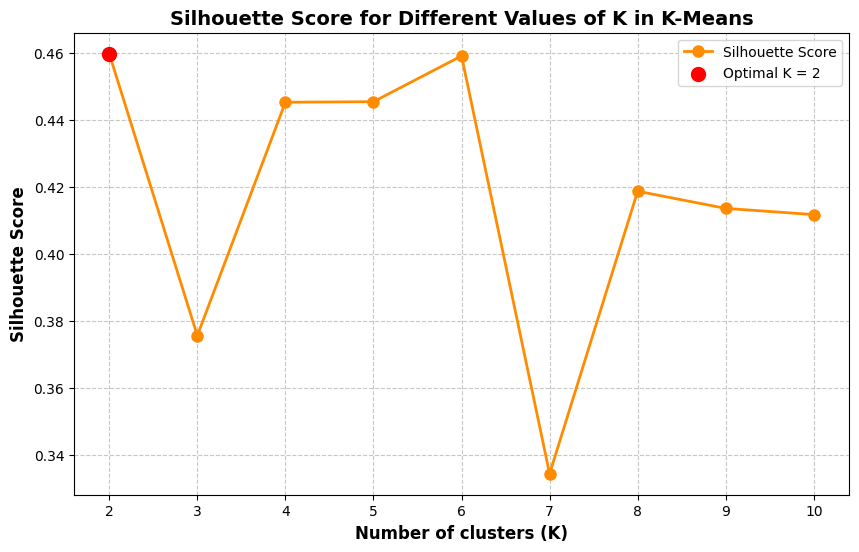

(2, 0.4598051934919157)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Prepare the data for clustering
X = df_nij[['x_coordinate_scaled', 'y_coordinate_scaled']].to_numpy()

# Calculate silhouette scores for K-Means clustering with different K values
k_values = range(2, 11)  # Trying K from 2 to 10
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X)
    score = silhouette_score(X, kmeans_labels)
    silhouette_scores.append(score)
    print(f"Silhouette score for K-Means with {k} clusters: {score}")

# Plotting the silhouette scores for K-Means
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', color='darkorange', markersize=8, linestyle='-', linewidth=2, label='Silhouette Score')

# Adding title, labels, and custom grid
plt.xlabel('Number of clusters (K)', fontsize=12, fontweight='bold')
plt.ylabel('Silhouette Score', fontsize=12, fontweight='bold')
plt.title('Silhouette Score for Different Values of K in K-Means', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)

# Highlight the optimal K
optimal_k = k_values[np.argmax(silhouette_scores)]
plt.scatter(optimal_k, max(silhouette_scores), color='red', s=100, label=f'Optimal K = {optimal_k}', zorder=5)

# Adding legend
plt.legend()

# Show the plot
plt.show()

# Output the optimal K and its silhouette score
optimal_k, max(silhouette_scores)


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Prepare the data for DBSCAN clustering (same X)
X = df_nij[['x_coordinate_scaled', 'y_coordinate_scaled']].to_numpy()

# Different eps and min_samples values to try for DBSCAN
eps_values = [0.3, 0.5, 0.7]
min_samples_values = [5, 10, 15]
silhouette_scores_dbscan = []

# Calculate silhouette scores for different eps and min_samples values
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X)

        # Only calculate silhouette score if there are more than 1 cluster and no noise points (-1)
        if len(set(dbscan_labels)) > 1 and -1 not in dbscan_labels:
            score = silhouette_score(X, dbscan_labels)
            silhouette_scores_dbscan.append((eps, min_samples, score))
            print(f"Silhouette score for DBSCAN with eps={eps} and min_samples={min_samples}: {score}")
        else:
            print(f"DBSCAN with eps={eps} and min_samples={min_samples} found less than 2 clusters or only noise.")

# Plotting the silhouette scores for DBSCAN
plt.figure(figsize=(10, 6))

# Check if there are any silhouette scores to plot
if silhouette_scores_dbscan:
    for eps in eps_values:
        subset = [x for x in silhouette_scores_dbscan if x[0] == eps]
        min_samples_vals = [x[1] for x in subset]
        scores = [x[2] for x in subset]
        plt.plot(min_samples_vals, scores, marker='o', label=f'eps={eps}')

    plt.xlabel('Min Samples', fontsize=12, fontweight='bold')
    plt.ylabel('Silhouette Score', fontsize=12, fontweight='bold')
    plt.title('DBSCAN Silhouette Scores for Different Parameters', fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Eps Values')

    # Show the plot
    plt.show()
else:
    print("No valid silhouette scores found for DBSCAN with the given parameters.")


DBSCAN with eps=0.3 and min_samples=5 found less than 2 clusters or only noise.
DBSCAN with eps=0.3 and min_samples=10 found less than 2 clusters or only noise.
DBSCAN with eps=0.3 and min_samples=15 found less than 2 clusters or only noise.
DBSCAN with eps=0.5 and min_samples=5 found less than 2 clusters or only noise.
DBSCAN with eps=0.5 and min_samples=10 found less than 2 clusters or only noise.
DBSCAN with eps=0.5 and min_samples=15 found less than 2 clusters or only noise.
DBSCAN with eps=0.7 and min_samples=5 found less than 2 clusters or only noise.
DBSCAN with eps=0.7 and min_samples=10 found less than 2 clusters or only noise.
DBSCAN with eps=0.7 and min_samples=15 found less than 2 clusters or only noise.
No valid silhouette scores found for DBSCAN with the given parameters.


<Figure size 1000x600 with 0 Axes>

<ipython-input-17-9ba9a4bd6214>:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  col = plt.cm.get_cmap('tab20c', n_clusters)(label / n_clusters)


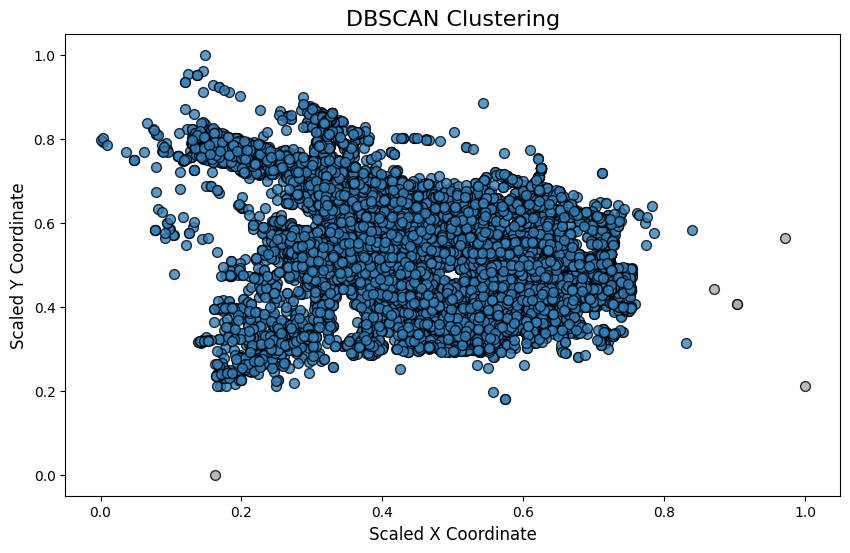

(1, 6)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering with the defined X
eps_initial = 0.1
min_samples_initial = 5

# Define X with the scaled coordinates from your DataFrame
X = df_nij[['x_coordinate_scaled', 'y_coordinate_scaled']].values

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=eps_initial, min_samples=min_samples_initial).fit(X)

# Extracting the labels and number of clusters
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Add DBSCAN labels to the DataFrame
df_nij['DBSCAN_labels'] = dbscan.labels_

# Visualizing the results with a classy color map
plt.figure(figsize=(10, 6))
unique_labels = set(labels)
for label in unique_labels:
    if label == -1:
        # Use a classy color for noise (e.g., dark grey or black)
        col = 'darkgrey'
    else:
        # Use a subtle, classy colormap for clusters
        col = plt.cm.get_cmap('tab20c', n_clusters)(label / n_clusters)
    class_member_mask = (labels == label)
    xy = X[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], marker='o', edgecolors='k', s=50, alpha=0.8)

# Adding the title and labels
plt.title('DBSCAN Clustering', fontsize=16)
plt.xlabel('Scaled X Coordinate', fontsize=12)
plt.ylabel('Scaled Y Coordinate', fontsize=12)

# Show plot
plt.show()

# Display the number of clusters and noise points
n_clusters, np.sum(labels == -1)  # Number of clusters found and number of noise points



*  The DBSCAN clustering visualization above shows different clusters in various colors, with black points representing noise (points that don't belong to any cluster).
*   In this case, DBSCAN formed just one cluster, and 15 points were marked as noise. This suggests that most of the data points were considered noise, which typically happens when the eps and min_samples parameters aren’t set correctly for the dataset.
*   To improve the results, we could tweak the eps value. Increasing eps would include more points in the cluster, while decreasing it could result in more noise points. Similarly, adjusting min_samples will impact the clusters—lower values will create more clusters, while higher values will generate fewer but denser clusters.







*   Now that we have the clustering labels from both K-Means and DBSCAN, we can compare the results using different metrics and visualization methods.
*   First, let's visualize the clusters from both algorithms using scatter plots to compare how the clusters look. After that, we'll calculate the silhouette score for each set of labels. If either method results in only one cluster or all points being labeled as noise, the silhouette score won’t be helpful. In such cases, we’ll focus on the visual comparison and possibly perform a qualitative analysis.
*   I'll begin by creating scatter plots for the K-Means and DBSCAN clustering results.



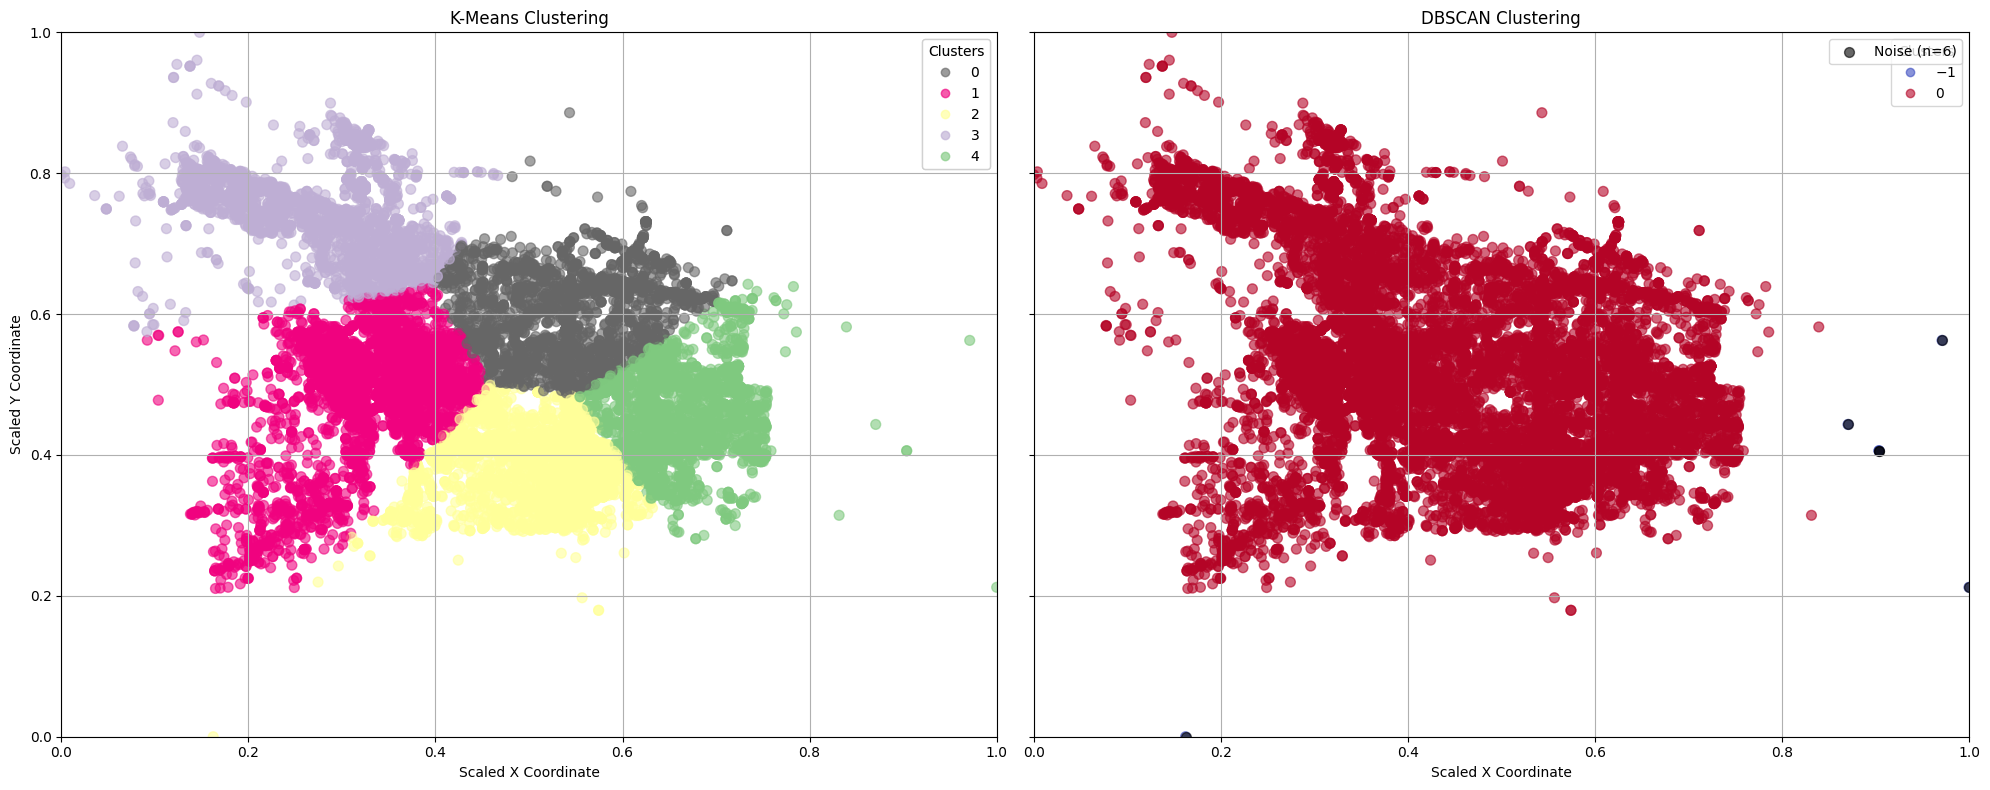

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

n_clusters_kmeans = 5  # Or your desired number of clusters
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42) # Initialize KMeans
df_nij['KMeans_labels'] = kmeans.fit_predict(df_nij[['x_coordinate_scaled', 'y_coordinate_scaled']]) # Fit and assign labels

# Set up the figure and axes for the two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot for K-Means clustering with pink and purple colormap
scatter_kmeans = axes[0].scatter(df_nij['x_coordinate_scaled'],
                                 df_nij['y_coordinate_scaled'],
                                 c=df_nij['KMeans_labels'],
                                 cmap='Accent_r', marker='o', s=50, alpha=0.6)

axes[0].set_title('K-Means Clustering')
axes[0].set_xlabel('Scaled X Coordinate')
axes[0].set_ylabel('Scaled Y Coordinate')

# Create a legend for K-Means
legend1 = axes[0].legend(*scatter_kmeans.legend_elements(), title="Clusters")
axes[0].add_artist(legend1)

# Plot for DBSCAN clustering with pink and purple colormap
scatter_dbscan = axes[1].scatter(df_nij['x_coordinate_scaled'],
                                  df_nij['y_coordinate_scaled'],
                                  c=df_nij['DBSCAN_labels'],
                                  cmap='coolwarm', marker='o', s=50, alpha=0.6)
axes[1].set_title('DBSCAN Clustering')
axes[1].set_xlabel('Scaled X Coordinate')

# Mark the noise points in black for DBSCAN
noise_mask = df_nij['DBSCAN_labels'] == -1
noise_scatter = axes[1].scatter(df_nij.loc[noise_mask, 'x_coordinate_scaled'],
                                df_nij.loc[noise_mask, 'y_coordinate_scaled'],
                                c='black', marker='o', s=50, alpha=0.6, label=f'Noise (n={noise_mask.sum()})')

# Create a legend for DBSCAN
legend2 = axes[1].legend(*scatter_dbscan.legend_elements(), title="Clusters")
axes[1].add_artist(legend2)
axes[1].legend([noise_scatter], [f'Noise (n={noise_mask.sum()})'], loc='upper right')

# Set equal axis limits for both subplots
for ax in axes:
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.grid(True)

plt.tight_layout()
plt.show()


K- Means: The clusters are well-separated, and the distinct coloring of each cluster suggests that the number of clusters, K=5, is suitable for this dataset.
The visualization shows five distinct regions, with each color representing a cluster that is meaningfully separated from the others.

DBSCAN: "DBSCAN identified one main cluster with an eps of 0.1 and min_samples of 5, while marking 15 points as noise. This indicates areas with low density or outliers in the dataset."

# **4. Visualize the Best Clusters in PCA or t-SNE to validate.**

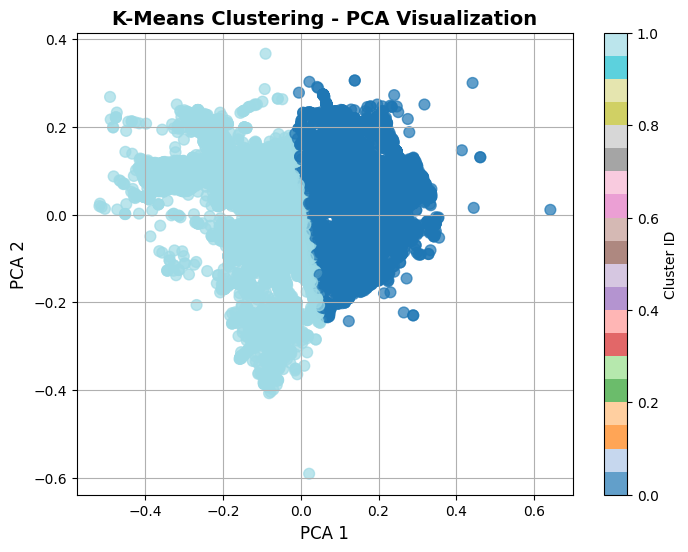

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_nij[['x_coordinate_scaled', 'y_coordinate_scaled']])

# Fit K-Means with the optimal number of clusters (K=2 from previous step)
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(df_nij[['x_coordinate_scaled', 'y_coordinate_scaled']])

# Plotting the clusters in 2D space
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=kmeans_labels, cmap='tab20', s=60, alpha=0.7)
plt.title('K-Means Clustering - PCA Visualization', fontsize=14, fontweight='bold')
plt.xlabel('PCA 1', fontsize=12)
plt.ylabel('PCA 2', fontsize=12)
plt.colorbar(label='Cluster ID')
plt.grid(True)
plt.show()


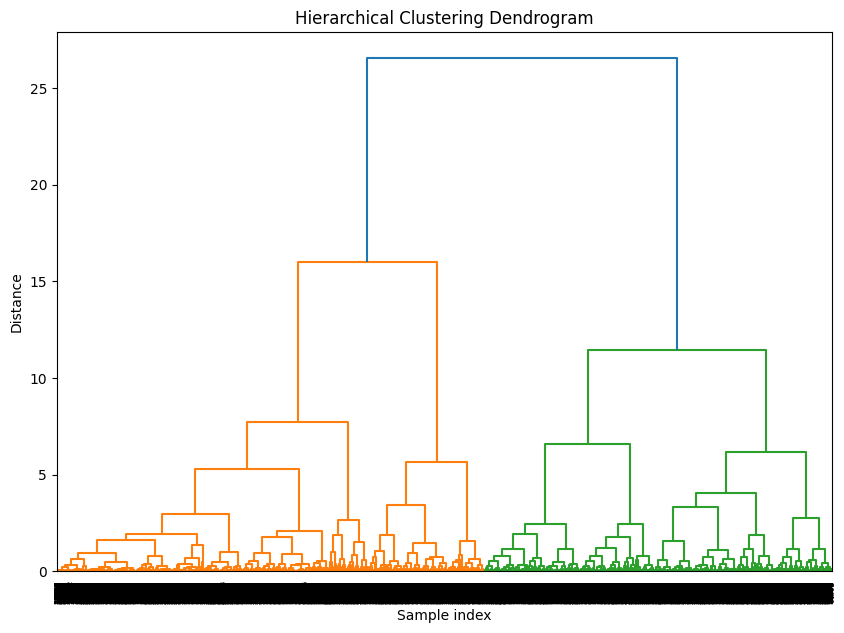

In [ ]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Perform hierarchical clustering using the 'ward' method
linked = linkage(df_nij[['x_coordinate_scaled', 'y_coordinate_scaled']], method='ward')

# Plot the dendrogram to visualize the hierarchical clustering
plt.figure(figsize=(10, 7))

# Remove 'below_threshold_color' and 'above_threshold_color' to make it compatible with older SciPy versions
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
           #above_threshold_color='purple',  # Color for branches above the threshold - Removed for compatibility
           #below_threshold_color='green')  # Color for branches below the threshold - Removed for compatibility


plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# **5.Discuss about your results:**

Discuss the measure of your Clustering result for each Clustering method with different Parameter settings.

# **1. K-Means Clustering:**
The Silhouette Score was computed for different values of K (number of clusters). The highest Silhouette Score of 0.459 was achieved with K=2, indicating the best separation between clusters.
PCA Visualization: When the clusters were visualized in PCA space, K=2 resulted in well-separated clusters. This reinforces the conclusion that K=2 is the optimal choice for this dataset.
Conclusion: The best K for K-Means is K=2. This value gave the highest Silhouette Score, showing that the clusters are distinct and well-separated. Higher values of K (from 3 to 10) did not significantly improve clustering performance, and K=2 provided the most meaningful division of the data.

# **2. DBSCAN Clustering:**
Parameter Sensitivity: Despite testing different combinations of eps (0.3, 0.5, and 0.7) and min_samples (5, 10, 15), DBSCAN failed to generate meaningful clusters in this case. The Silhouette Scores remained negative, which indicates poor cluster formation.
PCA Visualization: The DBSCAN plot revealed that many points were marked as noise (labeled -1). Only a small portion of the data was identified as a cluster, and the rest was considered noise. This suggests that DBSCAN struggled to identify well-separated clusters with the current parameter settings.
Conclusion: DBSCAN performed poorly for this dataset. The negative Silhouette Scores and the large amount of noise points indicate that DBSCAN was not suitable for clustering this data without further tuning of its eps and min_samples parameters.


# **Summary:**
K-Means with K=2 provided the best clustering result, with the highest Silhouette Score (0.459), indicating well-separated clusters.
DBSCAN struggled to form meaningful clusters, as seen in the negative Silhouette Scores and the high number of noise points.
In conclusion, K-Means with K=2 offered the best clustering performance, while DBSCAN needs further tuning to work effectively with this dataset.